In [ ]:
!wget https://he-s3.s3.amazonaws.com/media/hackathon/test-draft-3-643/cellular-image-classification/dc99623a-c-vista_data.zip

--2020-08-05 08:31:10--  https://he-s3.s3.amazonaws.com/media/hackathon/test-draft-3-643/cellular-image-classification/dc99623a-c-vista_data.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.129.64
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.129.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350979046 (335M) [application/zip]
Saving to: ‘dc99623a-c-vista_data.zip’

dc99623a-c-vista_da 100%[===================>] 334.72M  17.5MB/s    in 19s     

2020-08-05 08:31:30 (17.6 MB/s) - ‘dc99623a-c-vista_data.zip’ saved [350979046/350979046]



In [ ]:
!unzip "/content/dc99623a-c-vista_data.zip"


Archive:  /content/dc99623a-c-vista_data.zip
  inflating: sample.csv              
 extracting: test_final.zip          
  inflating: train.csv               
 extracting: train_final.zip         


In [ ]:
!unzip "train_final.zip" -d "train_data"
!unzip "test_final.zip" -d "test_data"

Streaming output truncated to the last 5000 lines.
  inflating: test_data/f55.png       
  inflating: test_data/f550.png      
  inflating: test_data/f5500.png     
  inflating: test_data/f5501.png     
  inflating: test_data/f5502.png     
  inflating: test_data/f5503.png     
  inflating: test_data/f5504.png     
  inflating: test_data/f5505.png     
  inflating: test_data/f5506.png     
  inflating: test_data/f5507.png     
  inflating: test_data/f5508.png     
  inflating: test_data/f5509.png     
  inflating: test_data/f551.png      
  inflating: test_data/f5510.png     
  inflating: test_data/f5511.png     
  inflating: test_data/f5512.png     
  inflating: test_data/f5513.png     
  inflating: test_data/f5514.png     
  inflating: test_data/f5515.png     
  inflating: test_data/f5516.png     
  inflating: test_data/f5517.png     
  inflating: test_data/f5518.png     
  inflating: test_data/f5519.png     
  inflating: test_data/f552.png      
  inflating: test_data/f5520.png     

In [ ]:
!pip install timm

     |████████████████████████████████| 215kB 4.5MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np
from fastai import *
import cv2
from fastai.vision import *
import matplotlib.pyplot as plt
import timm
from collections import OrderedDict, Counter

In [ ]:
df = pd.read_csv('train.csv')
submit = pd.read_csv('sample.csv')

In [ ]:
df.shape

(10600, 2)

In [ ]:
df.label.value_counts()

7     800
14    800
6     800
13    800
5     800
12    800
4     800
3     800
2     800
9     800
1     800
8     800
11    500
10    500
Name: label, dtype: int64

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(24)

In [ ]:
sz=224
bs=32
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=180)
data = (ImageList.from_df(df=df,path='train_data/',cols='id') 
        .split_by_rand_pct()
        #.split_from_df(col="val")
        .label_from_df(cols='label') 
        .transform(tfms,size=sz, padding_mode='border' , resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

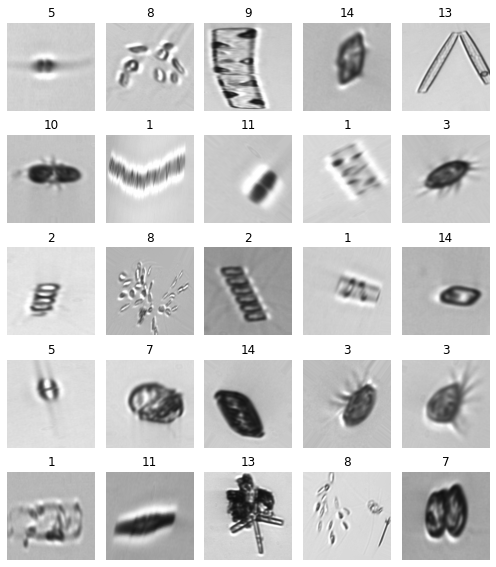

In [ ]:
data.show_batch(rows=5, figsize=(7, 8))

In [ ]:
learn = cnn_learner(data, timm.models.efficientnet_b1 , metrics=[accuracy]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


In [ ]:
learn.data.add_test(ImageList.from_df(submit,
                                      'test_data/',
                                      cols='id'))

In [ ]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/tmp/data"



def read_data(root):
    train_df = pd.read_csv(str(Path(root) / "train.csv"))
    test_df = pd.read_csv(str(Path(root) / "test.csv"))
    return train_df, test_df
    
    
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)
    

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.145394,0.645872,0.785377,01:22
1,0.884526,0.569498,0.812264,01:20
2,0.795150,0.482803,0.835849,01:19
3,0.627552,0.422494,0.852830,01:19
4,0.572252,0.348415,0.878774,01:19
5,0.516973,0.303901,0.899528,01:20
6,0.445313,0.271282,0.908962,01:19
7,0.389762,0.243065,0.919811,01:19
8,0.357769,0.235383,0.921698,01:19
9,0.364425,0.240427,0.920755,01:19


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 4.37E-06


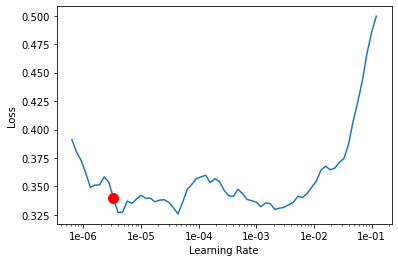

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [ ]:
l=5e-03
lr = 1e-03
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.365134,0.210852,0.932547,01:19
1,0.285445,0.199829,0.933962,01:18
2,0.256611,0.167768,0.946226,01:19
3,0.235161,0.155506,0.946698,01:19
4,0.179481,0.128969,0.960377,01:19
5,0.145693,0.124384,0.961321,01:19
6,0.143020,0.114185,0.965094,01:19
7,0.141813,0.116062,0.966038,01:19


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.74E-05
Min loss divided by 10: 1.06E-05


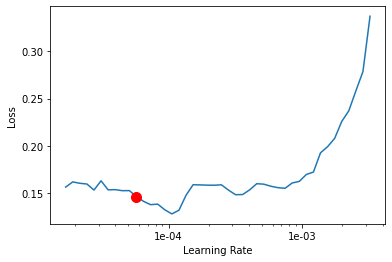

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=5e-06, end_lr=1)
learn.recorder.plot(suggestion=True)

In [ ]:
l=5e-04
lr = 1e-03
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.184226,0.150902,0.951887,01:30
1,0.266625,0.176437,0.938679,01:30
2,0.261465,0.224029,0.928302,01:29
3,0.192726,0.130299,0.953302,01:29
4,0.149396,0.139090,0.959434,01:29
5,0.098308,0.088494,0.975000,01:28
6,0.068616,0.091241,0.972170,01:29
7,0.045869,0.090165,0.973113,01:32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.06E-04
Min loss divided by 10: 1.69E-06


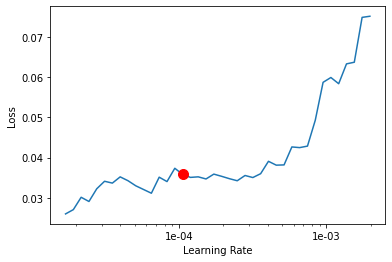

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=5e-06, end_lr=1)
learn.recorder.plot(suggestion=True)

In [ ]:
l=5e-04
lr = 1e-04
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.078866,0.103291,0.966509,01:31
1,0.116421,0.127636,0.965566,01:30
2,0.148423,0.121189,0.963679,01:31
3,0.129426,0.122952,0.964623,01:29
4,0.090404,0.109529,0.966509,01:29
5,0.067106,0.094605,0.973113,01:29
6,0.044354,0.085438,0.975472,01:29
7,0.037207,0.082703,0.976887,01:29


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.09E-06
Min loss divided by 10: 9.10E-07


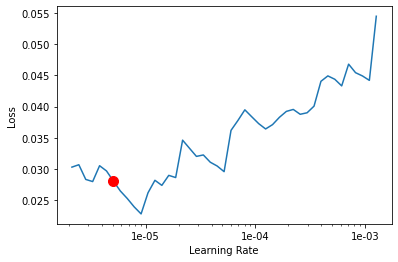

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=5e-07, end_lr=1)
learn.recorder.plot(suggestion=True)

In [ ]:
l=5e-05
lr = 1e-05
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.035524,0.083157,0.976415,01:30
1,0.034176,0.079477,0.977359,01:32
2,0.027324,0.081898,0.976415,01:31
3,0.029216,0.085231,0.978774,01:31
4,0.036052,0.084534,0.977359,01:30
5,0.024795,0.081825,0.978302,01:30
6,0.018003,0.081241,0.979245,01:31
7,0.020643,0.080228,0.977830,01:30


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
learn.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-05


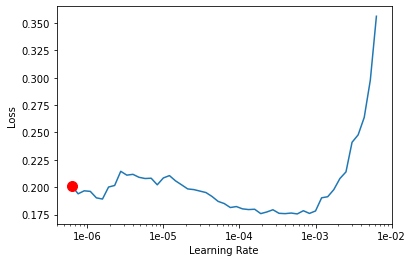

In [ ]:
## finding the LR
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2, slice(1e-06, lr/10),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.200200,0.141337,0.955660,01:31
1,0.188966,0.140888,0.954717,01:30


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
pred = learn.get_preds(DatasetType.Test)
pred_arr = np.array(pred[0])
np.save('effb1', pred_arr)
final_prd = pred_arr.argmax(1) + 1
submit.label = final_prd
submit.to_csv('s1.csv', index=False)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
learn = cnn_learner(data, timm.models.mixnet_xl , metrics=[accuracy]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mixnet_xl_ra-aac3c00c.pth" to /root/.cache/torch/hub/checkpoints/mixnet_xl_ra-aac3c00c.pth


In [ ]:
learn.data.add_test(ImageList.from_df(submit,
                                      'test_data/',
                                      cols='id'))

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.072582,0.596817,0.801887,01:32
1,0.797420,0.494317,0.826887,01:30
2,0.688273,0.556694,0.802830,01:29
3,0.637634,0.330974,0.896226,01:28
4,0.531025,0.292308,0.902358,01:27
5,0.436366,0.249500,0.919340,01:27
6,0.408878,0.263783,0.900000,01:27
7,0.341102,0.209654,0.927359,01:27
8,0.327137,0.198920,0.935849,01:28
9,0.336157,0.198117,0.934906,01:28


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.45E-04


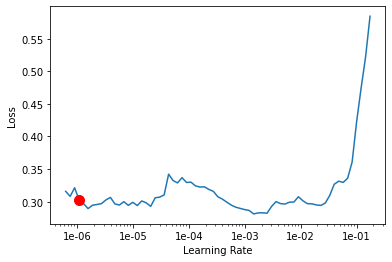

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [ ]:
l=1e-04
lr = 1e-02
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.397598,0.266418,0.903302,01:30
1,0.625350,0.408532,0.870283,01:29
2,0.576402,0.299626,0.899528,01:28
3,0.498863,0.298742,0.897170,01:29
4,0.399461,0.250036,0.916038,01:30
5,0.376429,0.224721,0.924528,01:30
6,0.316857,0.203427,0.933019,01:32
7,0.317363,0.201973,0.933962,01:32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.30E-06
Min loss divided by 10: 2.56E-05


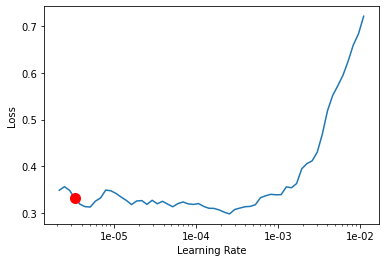

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=5e-07, end_lr=1)
learn.recorder.plot(suggestion=True)

In [ ]:
l=5e-05
lr = 1e-03
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(l,lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.280424,0.185778,0.938679,02:02
1,0.269065,0.172442,0.942924,02:03
2,0.237365,0.139944,0.953774,02:03
3,0.184400,0.123991,0.958962,02:04
4,0.160654,0.112617,0.961792,02:05
5,0.135374,0.108690,0.967925,02:05
6,0.125285,0.105329,0.968396,02:05
7,0.118051,0.101268,0.969340,02:05


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.45E-06
Min loss divided by 10: 4.68E-06


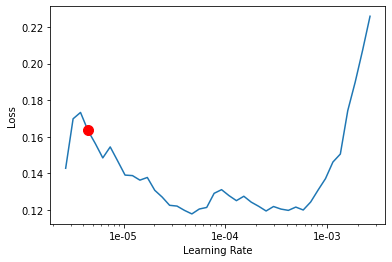

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=5e-07, end_lr=10)
learn.recorder.plot(suggestion=True)

In [41]:
l=5e-05
lr = 5e-03
#learn.fit_one_cycle(10, slice(l,lr))
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='train_loss',name='b1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.178023,0.123141,0.962736,02:04
1,0.299662,0.237352,0.925000,02:04
2,0.266702,0.138609,0.959906,02:04
3,0.235484,0.176959,0.946226,02:05
4,0.165504,0.139871,0.958019,02:05
5,0.115231,0.094234,0.976415,02:04
6,0.067206,0.098172,0.974528,02:04
7,0.047714,0.086378,0.976415,02:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [42]:
pred = learn.get_preds(DatasetType.Test)
pred_arr = np.array(pred[0])
np.save('mixnet', pred_arr)
final_prd = pred_arr.argmax(1) + 1
submit.label = final_prd
submit.to_csv('s2.csv', index=False)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [44]:
xx = np.load('effb1.npy')
yy = np.load('mixnet.npy')
pred = np.array(xx + yy)
submit.label = pred.argmax(1) + 1
submit.to_csv('s3.csv', index=False)